<a href="https://colab.research.google.com/github/MahmoudFarouq/faceVerification/blob/master/CNN_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import glorot_uniform
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
drop = 0.3

In [0]:
def resNetBlock_Identity(X, f, filters, stage, block):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  return X

In [0]:
def resNetBlock_convolutional(X, f, filters, stage, block, s=2):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  short_cut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid' , name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(short_cut)
  short_cut = BatchNormalization(axis = 3, name = bn_name_base + '1')(short_cut)
  
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  return X

In [0]:
def ResNet50(input_shape=(48, 48, 3), classes=4):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = resNetBlock_convolutional(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='b')
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='c')

    X = resNetBlock_convolutional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='b')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='c')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='d')

    X = resNetBlock_convolutional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='b')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='c')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='d')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='e')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='f')

    X = resNetBlock_convolutional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='b')
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [0]:
#!wget https://github.com/MahmoudFarouq/faceVerification/raw/master/dataSet/dataObject.pkl

In [54]:
!ls

dataObject.pkl	dataObject.pkl.1  sample_data


In [0]:
with open("dataObject.pkl", 'rb') as dataFile:
  X = pickle.load(dataFile)

In [0]:
y = [
    np.full((250, 1), 0), 
    np.full((250, 1), 1), 
    np.full((250, 1), 2), 
    np.full((250, 1), 3)
]
y = np.vstack(y)

# onehot encoding
y_encoder = OneHotEncoder(sparse=False, categories='auto')
y = y_encoder.fit_transform(y)

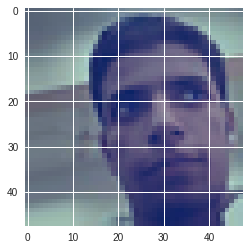

In [57]:
plt.imshow( X[750].reshape(48, 48, 3) )

In [58]:
X.shape, y.shape

((1000, 48, 48, 3), (1000, 4))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
model = ResNet50()

In [0]:
opt = Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [116]:
model.fit(
    X_train, 
    y_train,
    validation_data=(X_test,y_test),
    validation_split=0.8,
    epochs=250,
    shuffle=True,
    batch_size=128,
    verbose=1
)

Train on 800 samples, validate on 200 samples
Epoch 1/250
800/800 [==============================] - 3s 4ms/step - loss: 0.0705 - acc: 0.9725 - val_loss: 0.9273 - val_acc: 0.7900
Epoch 2/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0765 - acc: 0.9775 - val_loss: 0.7958 - val_acc: 0.8050
Epoch 3/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0932 - acc: 0.9625 - val_loss: 0.7994 - val_acc: 0.8250
Epoch 4/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0598 - acc: 0.9800 - val_loss: 0.9626 - val_acc: 0.8100
Epoch 5/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0588 - acc: 0.9788 - val_loss: 0.7785 - val_acc: 0.8000
Epoch 6/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0765 - acc: 0.9763 - val_loss: 0.7929 - val_acc: 0.8050
Epoch 7/250
800/800 [==============================] - 3s 3ms/step - loss: 0.0956 - acc: 0.9738 - val_loss: 1.0500 - val_acc: 0.7900
Epoch 8/250
800/800 [==

In [0]:
names = ['karim', 'omar', 'amr', 'farouq']

In [119]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 0s 2ms/step


[1.2138283634185791, 0.8]

'omar'

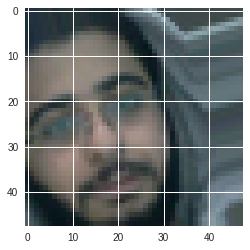

In [178]:
index = np.random.randint(0, 800)
plt.imshow(X_train[index].reshape(48, 48, 3))
names[np.argmax(model.predict(X_train[index].reshape(1, 48, 48, 3)))]

In [169]:
print("train acc: ", np.sum(np.argmax(model.predict(X_train), axis=1) == np.argmax(y_train, axis=1)) / 800)

train acc:  0.95625


In [148]:
print("test acc: ", np.sum(np.argmax(model.predict(X_test), axis=1) == np.argmax(y_test, axis=1)) / 200)

test acc:  0.79
